- http://matthewrocklin.com/blog/work/2017/03/28/dask-xgboost
- https://examples.dask.org/machine-learning/xgboost.html#Learn-more

In [1]:
PRFX='0315_1'

# setup

In [2]:
from pathlib import Path
import dask.dataframe as dd
import dask.array as da
import pandas as pd
from dask_ml.model_selection import train_test_split
import dask
print('dask.__version__', dask.__version__)
import xgboost
import dask_xgboost
from dask.distributed import Client
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

cols=[
'text_tokens',
'hashtags',
'tweet_id',
'present_media',
'present_links',
'present_domains',
'tweet_type',
'language',
'timestamp',

'engaged_user_id',
'engaged_follower_count',
'engaged_following_count',
'engaged_is_verified',
'engaged_account_creation_time',

'engaging_user_id',
'engaging_follower_count',
'engaging_following_count',
'engaging_is_verified',
'engaging_account_creation_time',

'engagee_follows_engager',
'reply_engagement_timestamp',
'retweet_engagement_timestamp',
'retweet_with_comment_engagement_timestamp',
'like_engagement_timestamp',
]

cols_val = cols[:-4]

tgts=['Retweet','Reply','Like','RT with comment',]
cols_tgt_tmstmp=[
    'retweet_engagement_timestamp',
    'reply_engagement_timestamp',
    'like_engagement_timestamp',
    'retweet_with_comment_engagement_timestamp',
]


/home/ubuntu/anaconda3/envs/dask-tutorial/lib/python3.7/site-packages/dask/array/random.py:27: FutureWarning: dask.array.random.doc_wraps is deprecated and will be removed in a future version
  FutureWarning,


dask.__version__ 2.11.0


In [3]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# prepare data

In [4]:
# !head -5000000 {p_in}/trn.tsv > {p_in}/trn5e6.tsv

In [5]:
df=dd.read_csv(f'{p_in}/trn1e5.tsv',
               sep='\x01',
               header=None,
               names=cols,)

In [6]:
ys=~df[cols_tgt_tmstmp].isna().to_dask_array(lengths=True)

In [7]:
df['len_toks']=df.text_tokens.apply(len, meta=('text_tokens', 'int64'))

# df.present_media.value_counts().compute()
# Photo                         182143
# Video                         108825
# Photo\tPhoto                   41294
# Photo\tPhoto\tPhoto\tPhoto     23275
# Photo\tPhoto\tPhoto            12932
# GIF                            10800

for media in ['Photo', 'Video', 'GIF']:
    df[f'has_media_{media}'] = df.present_media.fillna('').apply(lambda x: media in x, 
                                                                 meta=('present_media', 'string'))

df['num_hashtags'] = df.hashtags.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                  meta=('hashtags', 'string'))

df['num_links'] = df.present_links.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                  meta=('hashtags', 'string'))

df['num_domains'] = df.present_domains.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                  meta=('hashtags', 'string'))

df['tmdelta_engng_enged'] = df.engaging_account_creation_time - df.engaged_account_creation_time
df['tmdelta_enged_tweet'] = df.engaged_account_creation_time - df.timestamp
df['tmdelta_engng_tweet'] = df.engaging_account_creation_time - df.timestamp

In [8]:
cols_cat = [
    'tweet_type',
#     'language',
]

cols_num = ['timestamp', 'engaged_follower_count', 'engaged_following_count',
            'engaged_is_verified', 'engaged_account_creation_time', 'engaging_follower_count',
            'engaging_following_count', 'engaging_is_verified',
            'engaging_account_creation_time', 'engagee_follows_engager',
            'len_toks', 'has_media_Photo', 'has_media_Video', 'has_media_GIF', 
            'num_hashtags', 'num_links', 'num_domains', 
            'tmdelta_engng_enged', 'tmdelta_enged_tweet','tmdelta_engng_tweet']

cols_feat = cols_cat+cols_num

Xcat=dd.get_dummies(df[cols_cat].categorize()).to_dask_array(lengths=True)
Xnum=df[cols_num].to_dask_array(lengths=True)

X=da.concatenate([Xcat,Xnum],axis=1)
X=X.rechunk({1: X.shape[1]})

In [43]:
def makeX(df):
    df['len_toks']=df.text_tokens.apply(len, meta=('text_tokens', 'int64'))
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.present_media.fillna('').apply(lambda x: media in x, 
                                                                     meta=('present_media', 'string'))
    df['num_hashtags'] = df.hashtags.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                      meta=('hashtags', 'string'))
    df['num_links'] = df.present_links.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                      meta=('hashtags', 'string'))
    df['num_domains'] = df.present_domains.fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0,
                                                      meta=('hashtags', 'string'))
    df['tmdelta_engng_enged'] = df.engaging_account_creation_time - df.engaged_account_creation_time
    df['tmdelta_enged_tweet'] = df.engaged_account_creation_time - df.timestamp
    df['tmdelta_engng_tweet'] = df.engaging_account_creation_time - df.timestamp
    cols_cat0 = [
        'tweet_type',
#         'language',
    ]
    cols_num = ['timestamp', 'engaged_follower_count', 'engaged_following_count',
                'engaged_is_verified', 'engaged_account_creation_time', 'engaging_follower_count',
                'engaging_following_count', 'engaging_is_verified',
                'engaging_account_creation_time', 'engagee_follows_engager',
                'len_toks', 'has_media_Photo', 'has_media_Video', 'has_media_GIF', 
                'num_hashtags', 'num_links', 'num_domains', 
                'tmdelta_engng_enged', 'tmdelta_enged_tweet','tmdelta_engng_tweet']
    df_cat = dd.get_dummies(df[cols_cat0].categorize())
    cols_cat = list(df_cat.columns)
    cols_feat = cols_num+cols_cat
    Xcat=df_cat.to_dask_array(lengths=True)
    Xnum=df[cols_num].to_dask_array(lengths=True)
    X=da.concatenate([Xnum,Xcat],axis=1)
    X=X.rechunk({1: X.shape[1]})
    return X, cols_feat

In [44]:
X, cols_feat = makeX(df)

In [45]:
Xtrn, Xval, ystrn, ysval = train_test_split(X, ys, test_size=0.15)

# train

In [46]:
client = Client(n_workers=4, threads_per_worker=1)

/home/ubuntu/anaconda3/envs/dask-tutorial/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [47]:
params = {'objective': 'binary:logistic'}

tgt2bst={}
tgt2col2fscr={}
for i,tgt in enumerate(tgts):
    bst = dask_xgboost.train(client, params,
                             Xtrn, ystrn[:,i],
                             num_boost_round=20)
    tgt2bst[tgt]=bst
    print(dtnow(), tgt)
    
    fi2col=dict(zip(bst.feature_names, cols_feat))
    col2fi=dict(zip(cols_feat, bst.feature_names))
    fi2fscr=bst.get_fscore()
    col2fscr={col:fi2fscr.get(fi,0) for col,fi in col2fi.items()}
    tgt2col2fscr[tgt]=col2fscr

2020-03-15 17:58:54 Retweet
2020-03-15 17:59:06 Reply
2020-03-15 17:59:17 Like
2020-03-15 17:59:27 RT with comment


Retweet


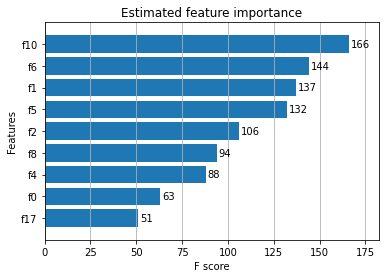

,0,1
10,len_toks,166
6,engaging_following_count,144
1,engaged_follower_count,137
5,engaging_follower_count,132
2,engaged_following_count,106
8,engaging_account_creation_time,94
4,engaged_account_creation_time,88
0,timestamp,63
17,tmdelta_engng_enged,51
19,tmdelta_engng_tweet,47


Reply


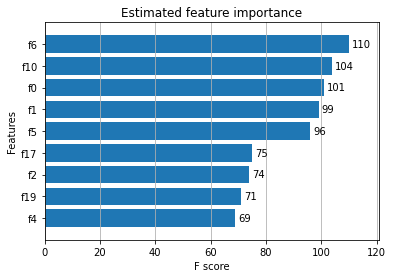

,0,1
6,engaging_following_count,110
10,len_toks,104
0,timestamp,101
1,engaged_follower_count,99
5,engaging_follower_count,96
17,tmdelta_engng_enged,75
2,engaged_following_count,74
19,tmdelta_engng_tweet,71
4,engaged_account_creation_time,69
8,engaging_account_creation_time,68


Like


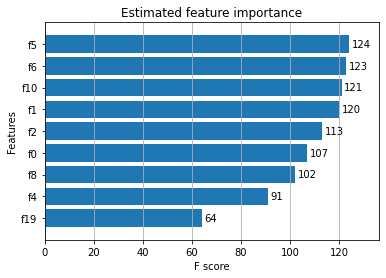

,0,1
5,engaging_follower_count,124
6,engaging_following_count,123
10,len_toks,121
1,engaged_follower_count,120
2,engaged_following_count,113
0,timestamp,107
8,engaging_account_creation_time,102
4,engaged_account_creation_time,91
19,tmdelta_engng_tweet,64
17,tmdelta_engng_enged,46


RT with comment


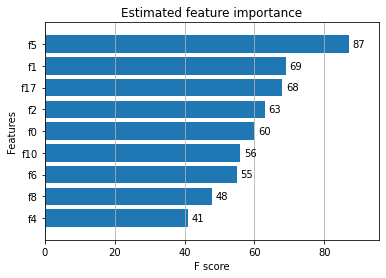

,0,1
5,engaging_follower_count,87
1,engaged_follower_count,69
17,tmdelta_engng_enged,68
2,engaged_following_count,63
0,timestamp,60
10,len_toks,56
6,engaging_following_count,55
8,engaging_account_creation_time,48
4,engaged_account_creation_time,41
19,tmdelta_engng_tweet,28


In [48]:
def show_feat_importance(bst):
    ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()

for i,tgt in enumerate(tgts):
    print(tgt)
    show_feat_importance(tgt2bst[tgt])
    col2fscr=tgt2col2fscr[tgt]
    display(pd.DataFrame(col2fscr.items()).sort_values(1, ascending=False))

# validate

In [49]:
tgt2yval={}
tgt2prdval={}
for i,tgt in enumerate(tgts):
    prdval = dask_xgboost.predict(client, tgt2bst[tgt], Xval).persist()
    yval, prdval = dask.compute(ysval[:,i], prdval)
    tgt2yval[tgt]=yval
    tgt2prdval[tgt]=prdval

In [50]:
def show_roc(prd,y):
    fpr, tpr, _ = roc_curve(y,prd)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, lw=3,
            label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title="ROC Curve",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()

Retweet
auc: 0.2237544528667011
rce: 6.755985849755053


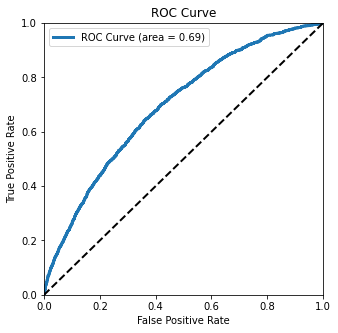

Reply
auc: 0.07499314205826946
rce: 8.358136772906722


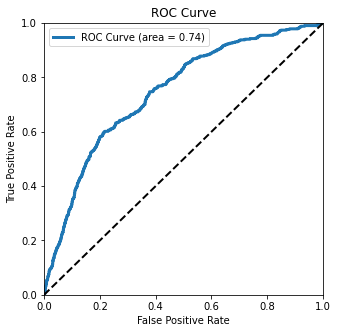

Like
auc: 0.6562787450375454
rce: 11.113375674574177


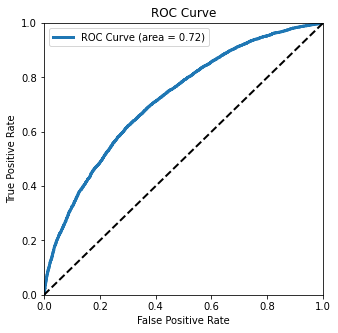

RT with comment
auc: 0.010645641385689197
rce: 0.25712600712631817


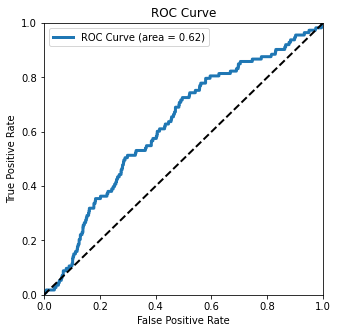

In [51]:
tgt2auc={}
tgt2rce={}
for i,tgt in enumerate(tgts):
    print(tgt)
    yval = tgt2yval[tgt]
    prdval = tgt2prdval[tgt]
    scr_auc=compute_prauc(prdval, yval)
    scr_rce=compute_rce(prdval, yval)
    tgt2auc[tgt]=scr_auc
    tgt2rce[tgt]=scr_rce
    print('auc:',scr_auc)
    print('rce:', scr_rce)
    show_roc(prdval, yval)

In [52]:
lst=[]
for tgt in ['Retweet','Reply','Like','RT with comment',]:
    lst+=[(f'PRAUC {tgt}',tgt2auc[tgt]),
          (f'RCE {tgt}',tgt2rce[tgt])]

In [53]:
pd.DataFrame(lst).T

,0,1,2,3,4,5,6,7
0,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RT with comment,RCE RT with comment
1,0.223754,6.75599,0.0749931,8.35814,0.656279,11.1134,0.0106456,0.257126


# infer

In [54]:
dftst=dd.read_csv(f'{p_in}/val1e4.tsv',
                  sep='\x01',
               header=None,
               names=cols_val,
               encoding='utf8')

In [55]:
dftst.head()

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,timestamp,engaged_user_id,engaged_follower_count,engaged_following_count,engaged_is_verified,engaged_account_creation_time,engaging_user_id,engaging_follower_count,engaging_following_count,engaging_is_verified,engaging_account_creation_time,engagee_follows_engager
0,101\t47185\t10157\t100986\t10343\t55422\t119\t...,NaN,7647B4E9DAF4C1D8973397DC2A04F3E3,Photo,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581703126,8A9AB92B775C62C4AB60DF6773A01571,13941,1216,False,1448292186,0000006C3074607050F1339DDCB890BB,27448,600,False,1520948869,True
1,101\t6006\t5086\t1939\t7418\t3601\t6406\t1913\...,NaN,CCBFBA5AFE7EFC03102EA8D0F86C4208,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581736431,187AC59639DA9A6F32F7CD118EDD58F7,476439,1478,False,1254447722,00000776B07587ECA9717BFC301F2D6E,102,659,False,1478011810,False
2,101\t56898\t137\t44851\t10317\t11490\t10112\t1...,NaN,E18C2DCFC5AF20C650A0FD94598E69B7,Video,NaN,NaN,Retweet,ECED8A16BE2A5E8871FD55F4842F16B1,1582061925,82626B53CB2AD3B469E4AE06EAA9D930,367,702,False,1518708926,00000860E80C67D8C46CE57C64DE9444,230,189,False,1541013180,True
3,101\t13497\t10437\t94005\t11161\t73632\t11067\...,NaN,26DC813FDF8546B757BB9141099F119E,NaN,D58137F9D688C88435FD64FBAEA82B97,E91CDEC8DC7ABF30592FA024616FF970,TopLevel,ECED8A16BE2A5E8871FD55F4842F16B1,1582110043,7AFE06FF54898A1E9C716F539831849E,278,1229,False,1243548061,00000865A1538142CDA5936B07FE4311,65,165,False,1452599043,True
4,101\t24781\t10152\t42041\t38268\t10301\t10798\...,NaN,30A33055566AAC9EB18734C4EAD11FE1,NaN,AEF0CC9FA7B389B9A2ADF1331F00B65B,42DD9E2D4B2C0B0A71E909A6049EC2C2,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581860270,D240DACE38CA84965270C86D47D3BF40,24313527,121,True,1177506290,00000865A1538142CDA5936B07FE4311,64,164,False,1452599043,False


In [56]:
Xtst, cols_feat=makeX(dftst)

In [57]:
tgt2prdtst={}
for i,tgt in enumerate(tgts):
    for i,tgt in enumerate(tgts):
        prdtst = dask_xgboost.predict(client, tgt2bst[tgt], Xtst).persist()
        prdtst = prdtst
        tgt2prdtst[tgt]=prdtst 

In [58]:
dfsub_ids = dftst[['tweet_id','engaged_user_id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [59]:
for tgt,dfsub in tgt2dfsub.items():
    dfsub.to_csv(f'{p_out}/{tgt}__{PRFX}.csv', 
                          index=False, 
                          header=False)